In [1]:
import functools
import os
import pickle
import time
from argparse import Namespace
import sys

import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow.compat.v2 as tf
import matplotlib.pyplot as plt

from absl import logging
logging.set_verbosity(logging.INFO)


sys.path.append('./deq-jax')
from src.mnist_fcn import mnist_dataset
from src.mnist_fcn.mnist_train import build_forward_fn, ce_loss_fn, Updater, CheckpointingUpdater, accuracy

sys.path.append('./spectral-density')
import density as density_lib
import lanczos as lanczos
import hessian_computation as hessian_computation

# Arguments & Setup

In [2]:
FLAGS = Namespace()
FLAGS.checkpoint_dir = './ckpt/mnist/'

FLAGS.use_deq = True
FLAGS.custom_vjp = True
FLAGS.max_iter = 15
FLAGS.feedfwd_layers = 12
FLAGS.d_model = 64

FLAGS.batch_size = 256
FLAGS.learning_rate = 1e-3
FLAGS.grad_clip_value = 0.25

LOG_EVERY = 50
EVAL_EVERY = 500
MAX_STEPS = 10 ** 5

In [3]:
# Create the dataset.
train_dataset = mnist_dataset.load("train", is_training=True, batch_size=FLAGS.batch_size)
train_dataset_eval = mnist_dataset.load("train", is_training=False, batch_size=10000)
test_dataset = mnist_dataset.load("test", is_training=False, batch_size=10000)

INFO:absl:Load dataset info from /h/ryoungj/tensorflow_datasets/mnist/3.0.1
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/h/ryoungj/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset for split train, from /h/ryoungj/tensorflow_datasets/mnist/3.0.1
INFO:absl:Load dataset info from /h/ryoungj/tensorflow_datasets/mnist/3.0.1
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/h/ryoungj/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset for split train, from /h/ryoungj/tensorflow_datasets/mnist/3.0.1
INFO:absl:Load dataset info from /h/ryoungj/tensorflow_datasets/mnist/3.0.1
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/h/ryoungj/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset for split

# Train Model

In [ ]:
# Set up the model, loss, and updater.
forward_fn = build_forward_fn(FLAGS.d_model, FLAGS.use_deq, FLAGS.custom_vjp, FLAGS.max_iter, FLAGS.feedfwd_layers)
forward_fn = hk.transform(forward_fn)
loss_fn = functools.partial(ce_loss_fn, forward_fn.apply)

optimizer = optax.chain(
    optax.clip_by_global_norm(FLAGS.grad_clip_value),
    optax.adam(FLAGS.learning_rate, b1=0.9, b2=0.99))

updater = Updater(forward_fn.init, loss_fn, optimizer)
updater = CheckpointingUpdater(updater, FLAGS.checkpoint_dir)

# Initialize parameters.
logging.info('Initializing parameters...')
rng = jax.random.PRNGKey(428)
data = next(train_dataset)
state = updater.init(rng, data)

logging.info('# of params: {}'.format(sum([p.size for p in jax.tree_leaves(state['params'])])))

logging.info('Starting train loop...')
prev_time = time.time()
for step in range(MAX_STEPS):
    data = next(train_dataset)
    state, metrics = updater.update(state, data)
    # We use JAX runahead to mask data preprocessing and JAX dispatch overheads.
    # Using values from state/metrics too often will block the runahead and can
    # cause these overheads to become more prominent.
    if step % LOG_EVERY == 0:
        steps_per_sec = LOG_EVERY / (time.time() - prev_time)
        metrics.update({'steps_per_sec': steps_per_sec})
        logging.info({k: float(v) for k, v in metrics.items()})

        if step % EVAL_EVERY == 0:
            train_accuracy = accuracy(forward_fn.apply, state['params'], state['rng'], next(train_dataset_eval))
            test_accuracy = accuracy(forward_fn.apply, state['params'], state['rng'], next(test_dataset))
            train_accuracy, test_accuracy = jax.device_get(
                (train_accuracy, test_accuracy))
            logging.info(f"[Step {step}] Train / Test accuracy: "
                         f"{train_accuracy:.3f} / {test_accuracy:.3f}.")

        prev_time = time.time()


INFO:absl:Initializing parameters...
INFO:absl:Loading checkpoint from ./ckpt/mnist/checkpoint_0010000.pkl
INFO:absl:# of params: 54986
INFO:absl:Starting train loop...
INFO:absl:Serializing experiment state to ./ckpt/mnist/checkpoint_0010000.pkl
INFO:absl:{'loss': 0.019821245223283768, 'step': 10000.0, 'steps_per_sec': 30.029983416689017}


# Reload Model

In [4]:
FLAGS.custom_vjp = False
FLAGS.batch_size = 256
order = 90
ckpt_steps = '0000000'

In [5]:
# Set up the model, loss, and updater.
forward_fn = build_forward_fn(FLAGS.d_model, FLAGS.use_deq, FLAGS.custom_vjp, FLAGS.max_iter, FLAGS.feedfwd_layers)
forward_fn = hk.transform(forward_fn)
loss_fn = functools.partial(ce_loss_fn, forward_fn.apply)

optimizer = optax.chain(
        optax.clip_by_global_norm(FLAGS.grad_clip_value),
        optax.adam(FLAGS.learning_rate, b1=0.9, b2=0.99))

updater = Updater(forward_fn.init, loss_fn, optimizer)
updater = CheckpointingUpdater(updater, FLAGS.checkpoint_dir)

# Initialize parameters.
logging.info('Initializing parameters...')
rng = jax.random.PRNGKey(428)
data = next(train_dataset)
state = updater.init(rng, data, ckpt_steps=ckpt_steps)

params = state['params']
logging.info('# of params: {}'.format(sum([p.size for p in jax.tree_leaves(params)])))

INFO:absl:Initializing parameters...
INFO:absl:Loading checkpoint from ./ckpt/mnist/checkpoint_0000000.pkl
INFO:absl:# of params: 54986


# Plot Hessian Spectrum

In [35]:
num_train = 60000
num_batches = num_train // FLAGS.batch_size

# make a generator that yields 1/60th (1000 examples)
batches_list = [next(train_dataset) for i in range(num_batches // 60)]

def batches_fn():
    for b in batches_list:
        yield b
        
def loss_fn_no_rng(params, data):
    return loss_fn(params, rng, data)

In [36]:
# Hessian-vector product function + Lanczos 
hvp, unravel, num_params = hessian_computation.get_hvp_fn(loss_fn_no_rng, params, batches_fn)
hvp_cl = lambda v: hvp(params, v) / len(batches_list) # Match the API required by lanczos_alg

In [37]:
print("num_params: {}".format(num_params))
start = time.clock()
hvp_cl(np.ones(num_params)) # first call of a jitted function compiles it
end = time.clock()
print("hvp compile time: {}".format(end-start))
start = time.clock()
hvp_cl(2*np.ones(num_params)) # second+ call will be much faster
end = time.clock()
print("hvp compute time: {}".format(end-start))

num_params: 54986


/scratch/ssd002/home/ryoungj/conda_envs/deq-jax/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/scratch/ssd002/home/ryoungj/conda_envs/deq-jax/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.
/scratch/ssd002/home/ryoungj/conda_envs/deq-jax/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


hvp compile time: 37.17534800000004
hvp compute time: 0.315084000000013


/scratch/ssd002/home/ryoungj/conda_envs/deq-jax/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


In [38]:
rng, split = jax.random.split(rng)
start = time.clock()
tridiag, vecs = lanczos.lanczos_alg(hvp_cl, num_params, order, split)
end = time.clock()
print("Lanczos time: {}".format(end-start)) # this should be ~order * hvp compute time
density, grids = density_lib.tridiag_to_density([tridiag], grid_len=10000, sigma_squared=1e-5)

/scratch/ssd002/home/ryoungj/conda_envs/deq-jax/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/scratch/ssd002/home/ryoungj/conda_envs/deq-jax/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


Lanczos time: 44.380889999999965


In [39]:
def plot(grids, density, label=None):
    plt.semilogy(grids, density, label=label)
    plt.ylim(1e-10, 1e2)
    plt.ylabel("Density")
    plt.xlabel("Eigenvalue")
    plt.legend()

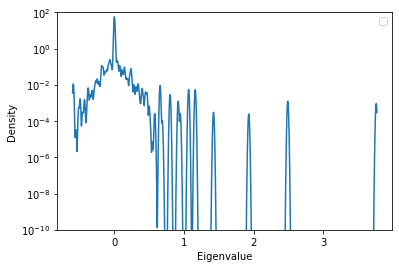

In [40]:
plot(grids, density)